<a href="https://colab.research.google.com/github/luganzimathiasjoseph/EDA_Defective_Tyre_Detection/blob/main/CNN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install torch torchvision matplotlib scikit-learn opencv-python lime shap torchcam  grad-cam

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score
import os
import warnings  # Suppress specific warnings
import numpy as np
import cv2
import lime
from lime import lime_image
import shap
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision import transforms as T
from torch.autograd import Variable
from pytorch_grad_cam.utils.image import show_cam_on_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import f1_score, precision_score

warnings.filterwarnings("ignore", category=UserWarning, module="torchvision.transforms.functional")


In [ ]:
# Define transformations for data preprocessing with enhanced data augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_data = datasets.ImageFolder('/content/drive/MyDrive/dataset/Digital images of defective and good condition tyres', transform=train_transform)
val_data = datasets.ImageFolder('/content/drive/MyDrive/dataset/validation', transform=val_transform)


In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)  # Define a custom CNN model based on ResNet18 architecture (without fully connected layers)

class CustomResNetCNN(nn.Module):
    def __init__(self):
        super(CustomResNetCNN, self).__init__()
        resnet18 = models.resnet18(pretrained=True)

        # Use only the convolutional layers of ResNet18
        self.features = nn.Sequential(*list(resnet18.children())[:-2])

        # Add custom layers after the convolutional layers
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(64, 2)  # Binary classification (defective or good condition)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize the model
model = CustomResNetCNN()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Checkpoint path
checkpoint_path = '/content/drive/MyDrive/CNN_AI.pth'

# Load the pre-trained model if it exists
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    print("Loaded pre-trained model.")
else:
    print("No pre-trained model found. Starting from scratch.")  # Lists to store training and validation metrics


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.8MB/s]


No pre-trained model found. Starting from scratch.


In [ ]:


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_f1_scores, val_f1_scores = [], []
train_precisions, val_precisions = [], []

# Best validation loss tracker
best_val_loss = float('inf')

# Training loop with progress display
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    train_accuracy = 100 * correct / total
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    train_precision = precision_score(all_labels, all_preds, average='weighted')

    # Validation loop
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            val_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += predicted.eq(target).sum().item()
            total += target.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    val_accuracy = 100 * correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    val_precision = precision_score(all_labels, all_preds, average='weighted')

    # Store metrics
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    train_precisions.append(train_precision)
    val_precisions.append(val_precision)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Print epoch-wise results
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Train F1: {train_f1:.4f}, Train Precision: {train_precision:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy:.2f}%, "
          f"Val F1: {val_f1:.4f}, Val Precision: {val_precision:.4f}")

    # Save the model if validation loss improves
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Improved validation loss. Model saved.")

print("Training Complete!")


Epoch 1/10: Train Loss: 0.5318, Train Accuracy: 71.78%, Train F1: 0.6973, Train Precision: 0.7525, Val Loss: 0.3757, Val Accuracy: 89.81%, Val F1: 0.8983, Val Precision: 0.8997
Improved validation loss. Model saved.
Epoch 2/10: Train Loss: 0.3912, Train Accuracy: 83.29%, Train F1: 0.8329, Train Precision: 0.8330, Val Loss: 0.2000, Val Accuracy: 91.72%, Val F1: 0.9174, Val Precision: 0.9195
Improved validation loss. Model saved.
Epoch 3/10: Train Loss: 0.2544, Train Accuracy: 91.37%, Train F1: 0.9137, Train Precision: 0.9137, Val Loss: 0.2661, Val Accuracy: 91.08%, Val F1: 0.9103, Val Precision: 0.9125
Epoch 4/10: Train Loss: 0.2394, Train Accuracy: 89.18%, Train F1: 0.8920, Train Precision: 0.8937, Val Loss: 0.2726, Val Accuracy: 89.17%, Val F1: 0.8920, Val Precision: 0.8982
Epoch 5/10: Train Loss: 0.1780, Train Accuracy: 93.42%, Train F1: 0.9343, Train Precision: 0.9343, Val Loss: 0.3745, Val Accuracy: 85.99%, Val F1: 0.8595, Val Precision: 0.8877
Epoch 6/10: Train Loss: 0.1203, Train

Test Accuracy: 92.90%
Test F1 Score: 0.9292
Test Precision: 0.9332


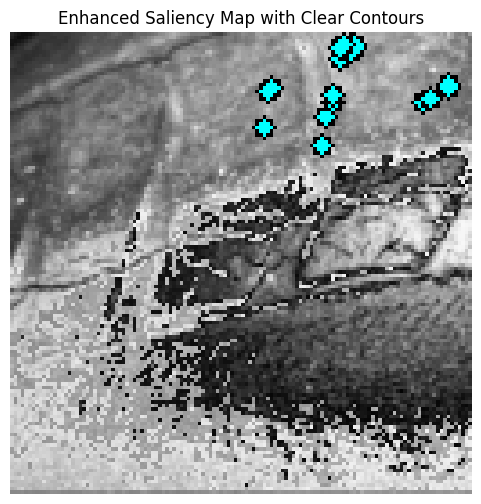

Original input image shape: (1, 3, 128, 128)
Transformed input image shape: (128, 128, 3)
Min pixel value: -0.9764706 Max pixel value: 0.9843137


  0%|          | 0/1000 [00:00<?, ?it/s]

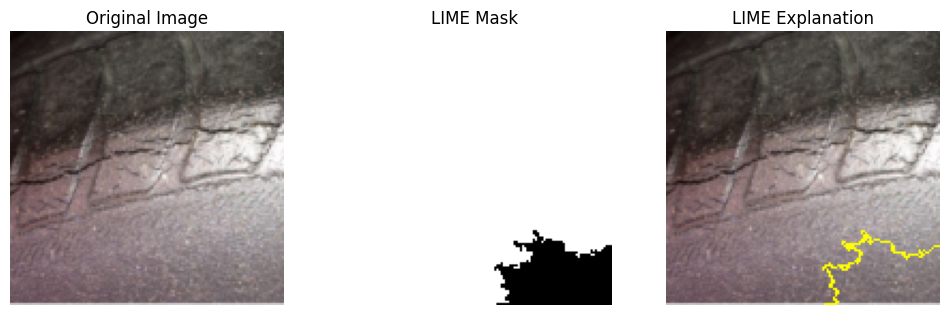

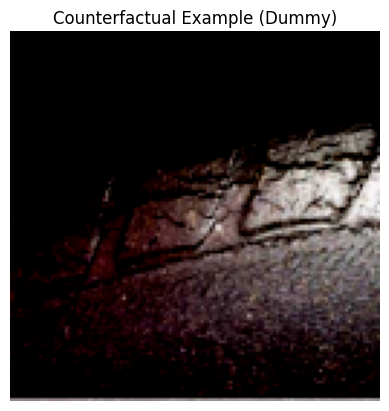

In [ ]:
test_data = datasets.ImageFolder('/content/drive/MyDrive/dataset/test', transform=val_transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

# Test Model Evaluation
test_loss = 0
correct = 0
total = 0
all_preds, all_labels = [], []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)

        test_loss += loss.item()
        _, predicted = torch.max(output, 1)
        correct += predicted.eq(target).sum().item()
        total += target.size(0)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

test_accuracy = 100 * correct / total
test_f1 = f1_score(all_labels, all_preds, average='weighted')
test_precision = precision_score(all_labels, all_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")

# ---------------------------
#  🔍 EXPLAINABLE AI METHODS
# ---------------------------

# Get a sample image from test_loader
sample_image, sample_label = next(iter(test_loader))
sample_image, sample_label = sample_image[0].to(device), sample_label[0].item()  # Get first image
sample_image = sample_image.unsqueeze(0)  # Add batch dimension

# Function to compute and refine the saliency map
def refined_saliency_map(model, input_image, target_class, threshold=0.7):
    input_image.requires_grad_()

    # Forward pass
    output = model(input_image)
    loss = output[0, target_class]

    # Backward pass
    model.zero_grad()
    loss.backward()

    # Compute saliency
    saliency, _ = torch.max(input_image.grad.abs(), dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    # Normalize to [0,1] for better visualization
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

    # Threshold to focus on key areas
    saliency[saliency < threshold] = 0  # Keep only important features

    return saliency

# Compute the refined saliency map
saliency = refined_saliency_map(model, sample_image, sample_label, threshold=0.7)

# Convert original image for overlay
original_image = sample_image.squeeze().detach().permute(1,2,0).cpu().numpy()

# Convert saliency to heatmap (removing blue)
heatmap = cv2.applyColorMap((saliency * 255).astype(np.uint8), cv2.COLORMAP_HOT)

# Blend heatmap with the original grayscale tire image
gray_tire = cv2.cvtColor((original_image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
heatmap_gray = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Improve contrast by normalizing heatmap before overlay
heatmap_gray = cv2.normalize(heatmap_gray, None, 0, 255, cv2.NORM_MINMAX)

# Blend the grayscale tire image with the heatmap
overlay = cv2.addWeighted(gray_tire, 0.5, heatmap_gray, 0.5, 0)

# Find contours in the saliency map using Otsu’s thresholding for better separation
_, thresh = cv2.threshold(heatmap_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Convert grayscale tire image to BGR for color overlay
contour_image = cv2.cvtColor(gray_tire, cv2.COLOR_GRAY2BGR)

# **Enhanced Contour Visualization**
for contour in contours:
    # Draw an outline for better visibility (black border)
    cv2.drawContours(contour_image, [contour], -1, (0, 0, 0), 5)  # Black border
    # Draw the actual contour in yellow
    cv2.drawContours(contour_image, [contour], -1, (0, 255, 255), 3)  # Yellow contour

# Display final image with improved contour overlay
plt.figure(figsize=(6,6))
plt.imshow(contour_image)
plt.title("Enhanced Saliency Map with Clear Contours")
plt.axis("off")
plt.show()


def lime_explanation(model, input_image, device):
    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        tensor_images = torch.tensor(images.transpose(0, 3, 1, 2)).float().to(device)
        outputs = model(tensor_images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
        return probabilities  # Ensure shape is (batch_size, num_classes)

    # Convert input image properly
    input_image_np = input_image.cpu().detach().numpy()

    # Debugging: Print input shape
    print("Original input image shape:", input_image_np.shape)

    if len(input_image_np.shape) == 4:  # Remove batch dimension if it exists
        input_image_np = input_image_np[0]

    if input_image_np.shape[0] in [1, 3]:  # If channels-first (C, H, W)
        input_image_np = input_image_np.transpose(1, 2, 0)  # Convert to (H, W, C)

    print("Transformed input image shape:", input_image_np.shape)  # Debugging check
    print("Min pixel value:", input_image_np.min(), "Max pixel value:", input_image_np.max())

    # Ensure input image is in range [0,1]
    input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min() + 1e-5)

    # Generate LIME explanation
    explanation = explainer.explain_instance(
        input_image_np,
        predict_fn,
        top_labels=1,
        hide_color=None,  # Keeps original colors
        num_samples=1000
    )

    # Get image and mask with proper normalization
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,  # Increase features to highlight more areas
        hide_rest=False  # Show full image instead of black background
    )

    # Normalize temp image correctly
    temp = (temp - temp.min()) / (temp.max() - temp.min() + 1e-5)

    # Apply boundaries
    lime_result = mark_boundaries(temp, mask)

    return input_image_np, mask, lime_result

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming 'model' is your trained PyTorch model and 'sample_image' is your input image tensor
input_image_np, mask, lime_result = lime_explanation(model, sample_image, device)

# Displaying the images for debugging
plt.figure(figsize=(12, 4))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(input_image_np)
plt.title("Original Image")
plt.axis("off")

# LIME Mask
plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("LIME Mask")
plt.axis("off")

# LIME Explanation
plt.subplot(1, 3, 3)
plt.imshow(np.clip(lime_result, 0, 1))
plt.title("LIME Explanation")
plt.axis("off")

plt.show()


# ✅ COUNTERFACTUAL (Dummy Example)
def counterfactual_explanation(model, input_image):
    counterfactual = input_image.clone().detach()
    return counterfactual

counterfactual = counterfactual_explanation(model, sample_image)
plt.imshow(counterfactual.squeeze().cpu().numpy().transpose(1, 2, 0))
plt.title("Counterfactual Example (Dummy)")
plt.axis("off")
plt.show()


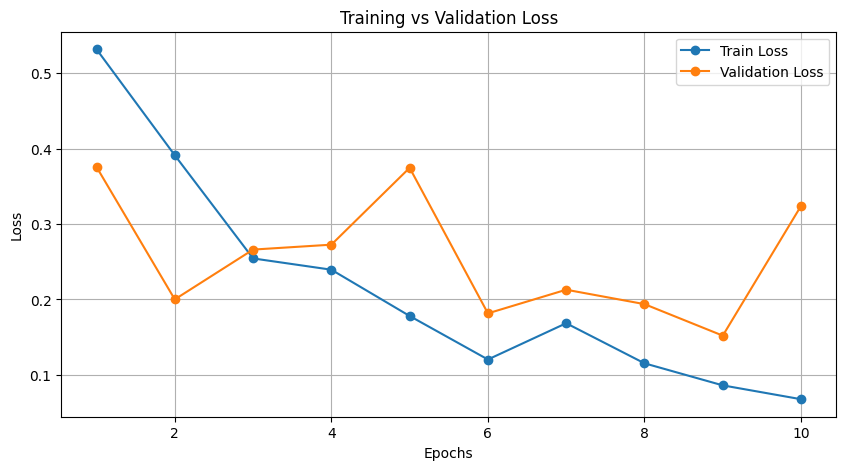

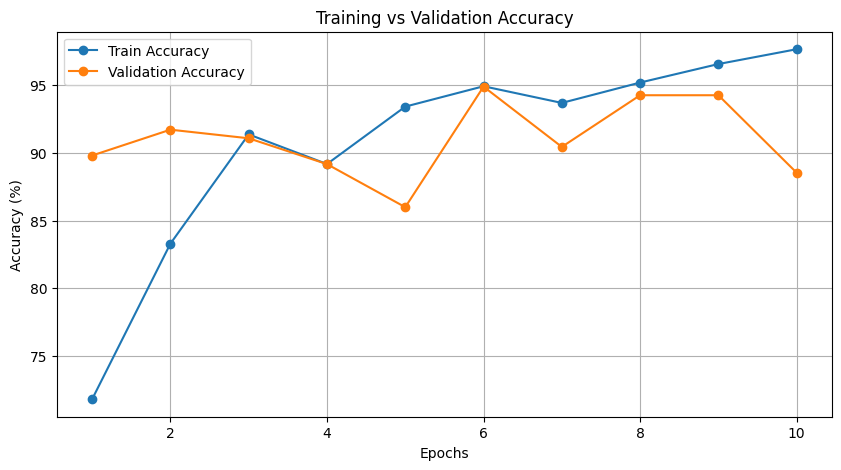

In [ ]:
# Visualizing the results
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()